In [135]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import datetime
from helpers import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [136]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../../train.csv' # TODO: download train data and supply path here 
y, tX_starting, ids = load_csv_data(DATA_TRAIN_PATH,sub_sample=False)

In [137]:
#tX[tX==-999]=0

# Pandas

In [138]:
import pandas as pd

In [205]:
# General data description
pd_data=pd.read_csv(DATA_TRAIN_PATH)
pd_data=pd_data.replace({'s':1,'b':-1})
del pd_data['Id']
pd_data.Prediction.describe()

count    250000.000000
mean         -0.314664
std           0.949205
min          -1.000000
25%          -1.000000
50%          -1.000000
75%           1.000000
max           1.000000
Name: Prediction, dtype: float64

In [140]:
# Number of nan
pd_data[pd_data==-999].count()

Prediction                          0
DER_mass_MMC                    38114
DER_mass_transverse_met_lep         0
DER_mass_vis                        0
DER_pt_h                            0
DER_deltaeta_jet_jet           177457
DER_mass_jet_jet               177457
DER_prodeta_jet_jet            177457
DER_deltar_tau_lep                  0
DER_pt_tot                          0
DER_sum_pt                          0
DER_pt_ratio_lep_tau                0
DER_met_phi_centrality              0
DER_lep_eta_centrality         177457
PRI_tau_pt                          0
PRI_tau_eta                         0
PRI_tau_phi                         0
PRI_lep_pt                          0
PRI_lep_eta                         0
PRI_lep_phi                         0
PRI_met                             0
PRI_met_phi                         0
PRI_met_sumet                       0
PRI_jet_num                         0
PRI_jet_leading_pt              99913
PRI_jet_leading_eta             99913
PRI_jet_lead

In [141]:
# Correlation matrix
pd_data2=pd_data.replace({-999:0})
corr_matrix2=pd_data2.corr()
corr_matrix2.Prediction

Prediction                     1.000000
DER_mass_MMC                   0.161623
DER_mass_transverse_met_lep   -0.351428
DER_mass_vis                  -0.014055
DER_pt_h                       0.192526
DER_deltaeta_jet_jet           0.227925
DER_mass_jet_jet               0.227832
DER_prodeta_jet_jet           -0.189891
DER_deltar_tau_lep             0.012245
DER_pt_tot                    -0.015287
DER_sum_pt                     0.153236
DER_pt_ratio_lep_tau          -0.195398
DER_met_phi_centrality         0.271752
DER_lep_eta_centrality         0.223175
PRI_tau_pt                     0.235238
PRI_tau_eta                   -0.000943
PRI_tau_phi                   -0.004403
PRI_lep_pt                    -0.031948
PRI_lep_eta                    0.001516
PRI_lep_phi                    0.004125
PRI_met                        0.022466
PRI_met_phi                    0.007475
PRI_met_sumet                  0.135520
PRI_jet_num                    0.133549
PRI_jet_leading_pt             0.165253


In [142]:
pd_data3=pd_data.replace({-999:-10})
corr_matrix3=pd_data3.corr()

In [143]:
corr_matrix=pd_data.corr()
corr_matrix.Prediction


Prediction                     1.000000
DER_mass_MMC                   0.239149
DER_mass_transverse_met_lep   -0.351428
DER_mass_vis                  -0.014055
DER_pt_h                       0.192526
DER_deltaeta_jet_jet           0.141646
DER_mass_jet_jet               0.191766
DER_prodeta_jet_jet            0.140554
DER_deltar_tau_lep             0.012245
DER_pt_tot                    -0.015287
DER_sum_pt                     0.153236
DER_pt_ratio_lep_tau          -0.195398
DER_met_phi_centrality         0.271752
DER_lep_eta_centrality         0.141346
PRI_tau_pt                     0.235238
PRI_tau_eta                   -0.000943
PRI_tau_phi                   -0.004403
PRI_lep_pt                    -0.031948
PRI_lep_eta                    0.001516
PRI_lep_phi                    0.004125
PRI_met                        0.022466
PRI_met_phi                    0.007475
PRI_met_sumet                  0.135520
PRI_jet_num                    0.133549
PRI_jet_leading_pt             0.157604


In [144]:
synthesis=corr_matrix[['Prediction']].copy()
synthesis['PredictionCorrected']=corr_matrix2.Prediction
synthesis['PredictionNan-10']=corr_matrix3.Prediction
synthesis['id']=range(-1,synthesis.shape[0]-1)
synthesis

,Prediction,PredictionCorrected,PredictionNan-10,id
Prediction,1.000000,1.000000,1.000000,-1
DER_mass_MMC,0.239149,0.161623,0.168419,0
DER_mass_transverse_met_lep,-0.351428,-0.351428,-0.351428,1
DER_mass_vis,-0.014055,-0.014055,-0.014055,2
DER_pt_h,0.192526,0.192526,0.192526,3
DER_deltaeta_jet_jet,0.141646,0.227925,0.169810,4
DER_mass_jet_jet,0.191766,0.227832,0.227817,5
DER_prodeta_jet_jet,0.140554,-0.189891,0.058306,6
DER_deltar_tau_lep,0.012245,0.012245,0.012245,7
DER_pt_tot,-0.015287,-0.015287,-0.015287,8


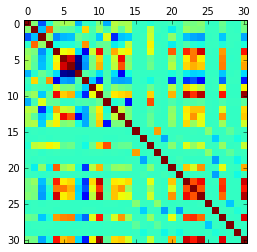

In [172]:
plt.matshow(pd_data2.corr())

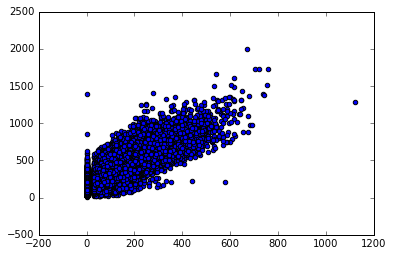

In [170]:
plt.scatter(pd_data2[[24]],pd_data2[[22]])

# Data analysis

/home/stefano/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


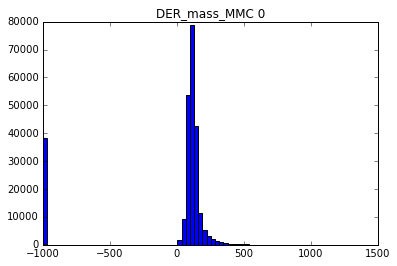

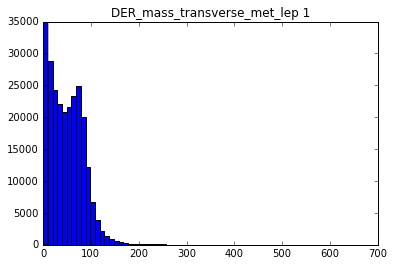

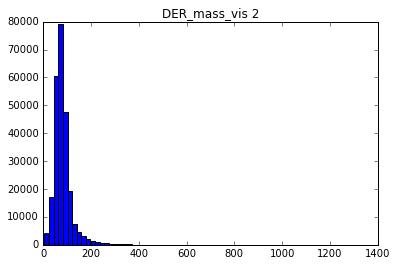

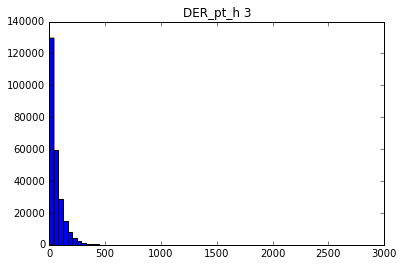

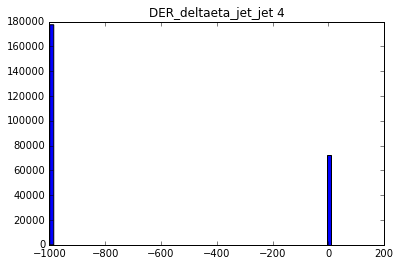

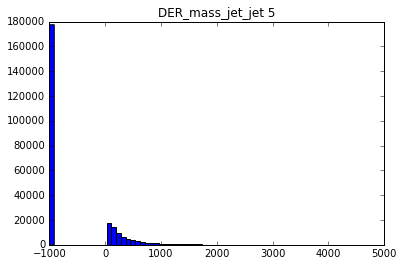

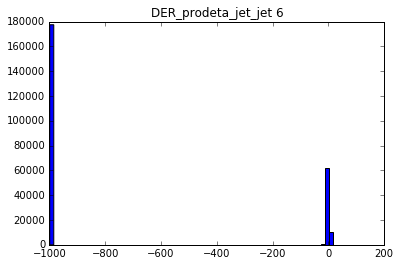

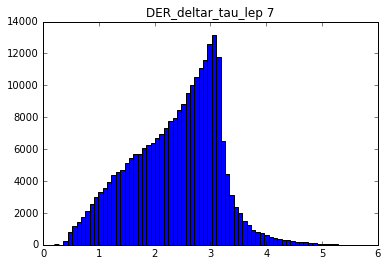

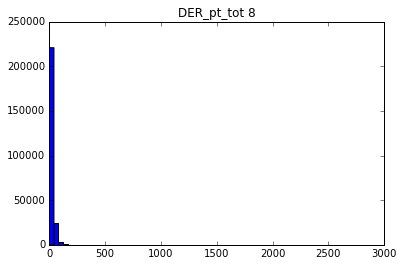

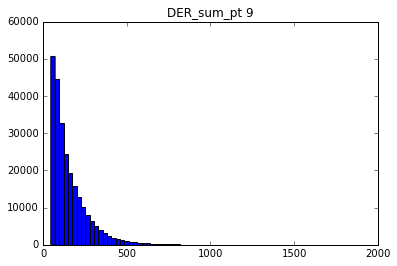

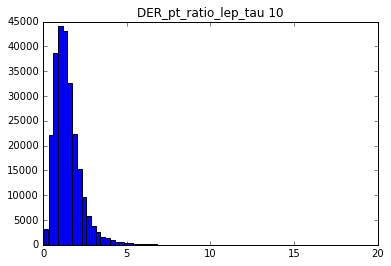

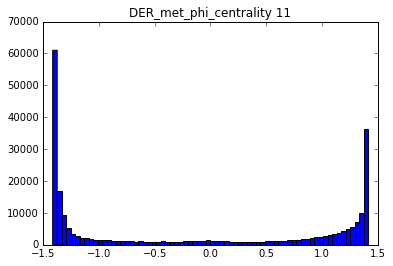

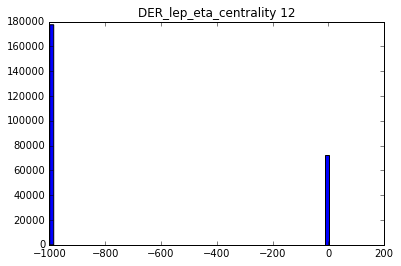

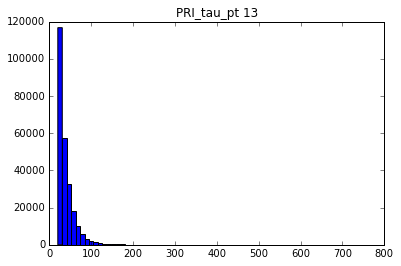

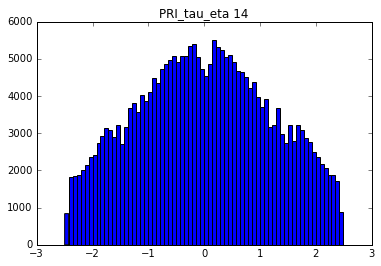

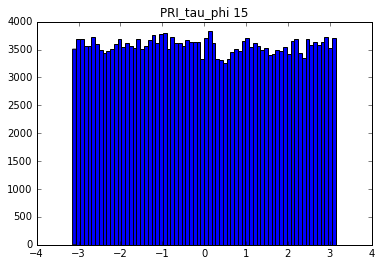

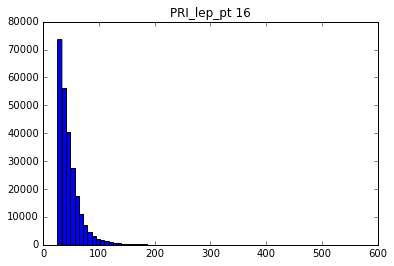

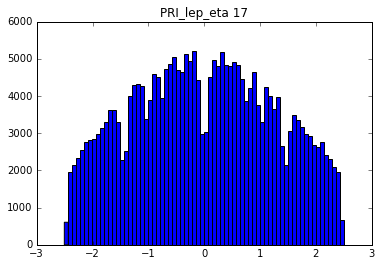

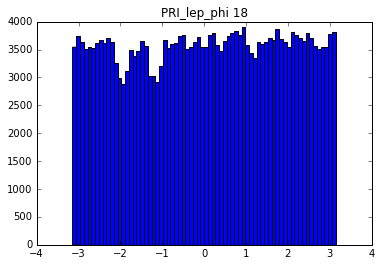

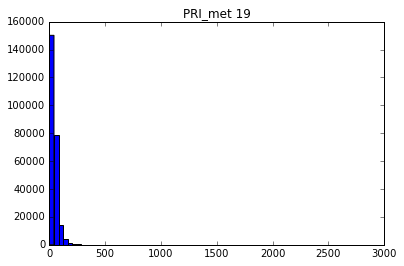

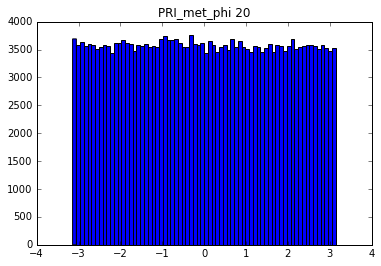

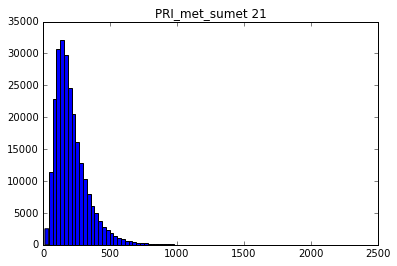

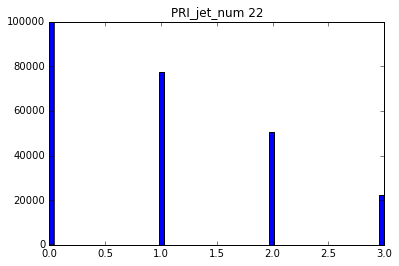

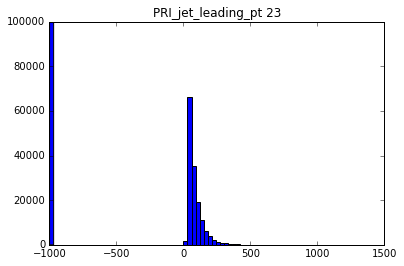

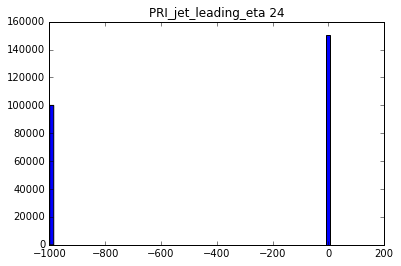

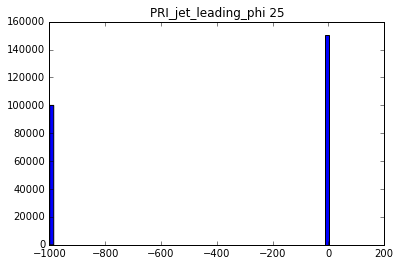

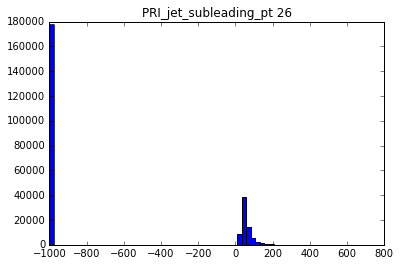

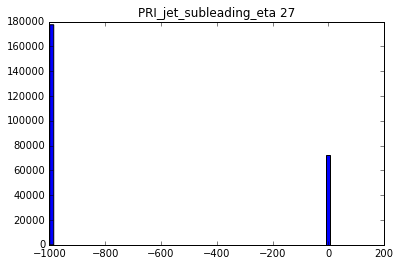

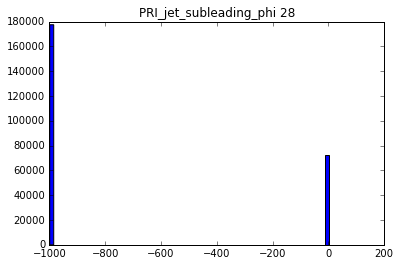

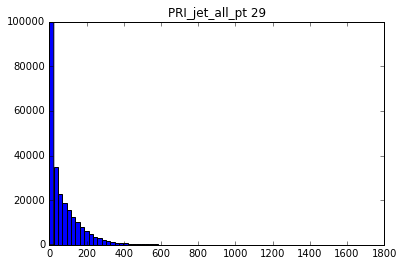

In [146]:
names=pd_data.columns.values

for i in range(tX_starting.shape[1]):
    plt.figure()
    plt.title(names[i+1]+" "+str(i))
    plt.hist(tX_starting[:,i],bins=70)

/home/stefano/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


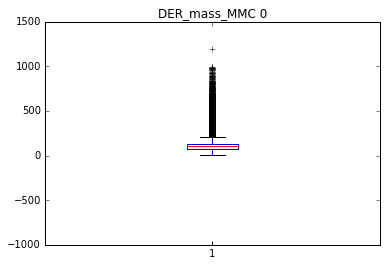

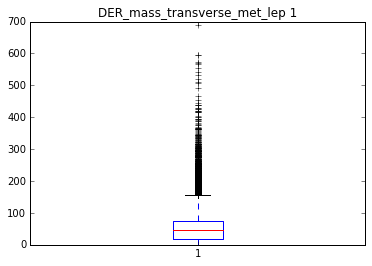

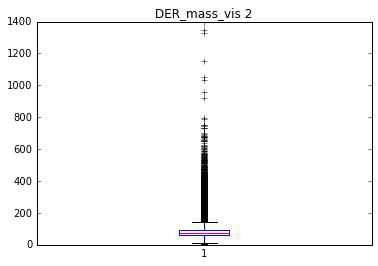

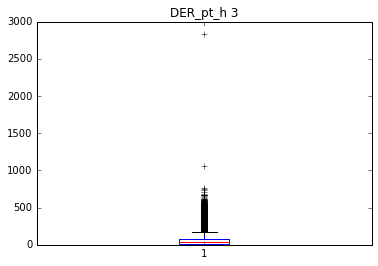

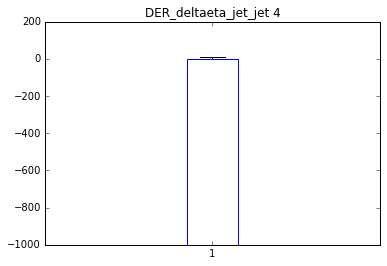

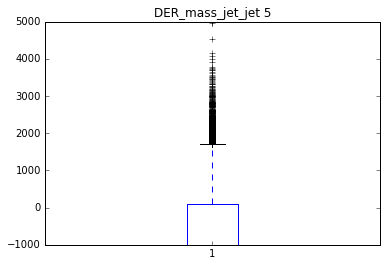

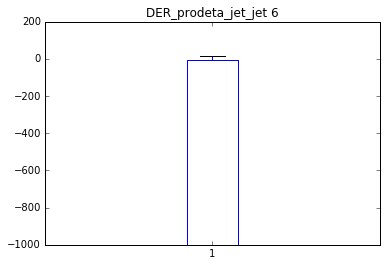

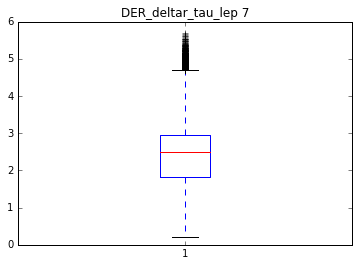

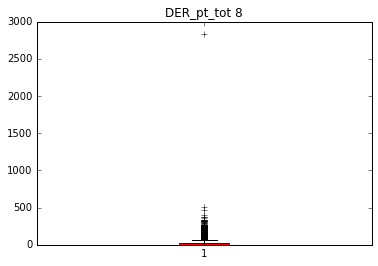

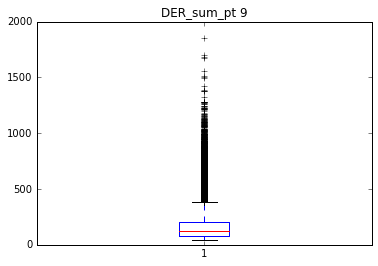

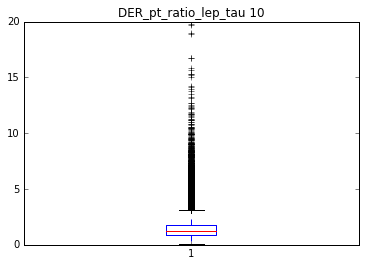

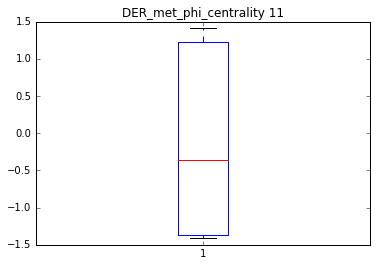

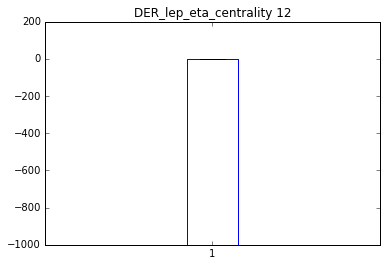

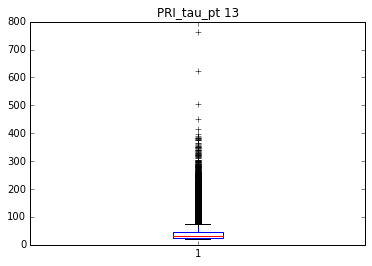

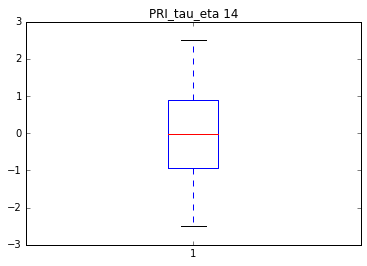

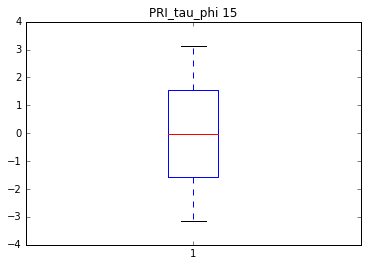

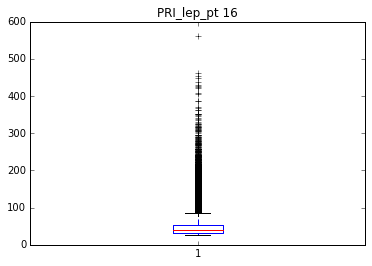

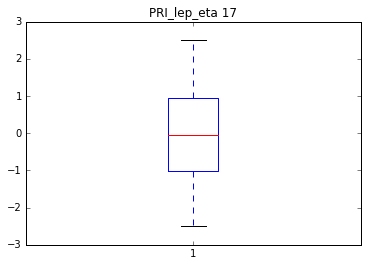

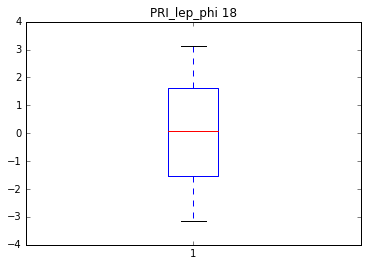

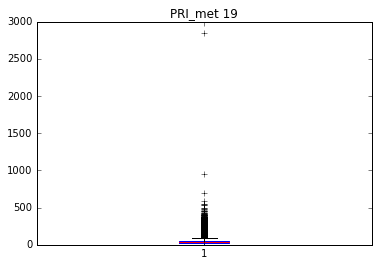

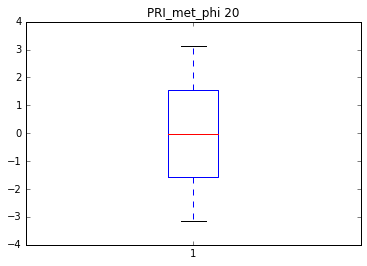

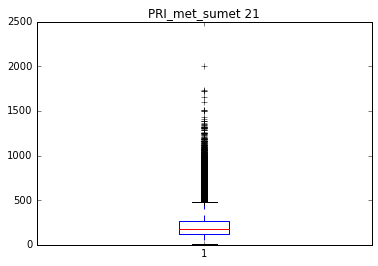

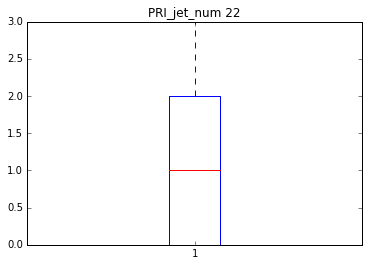

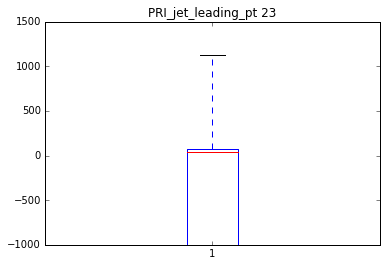

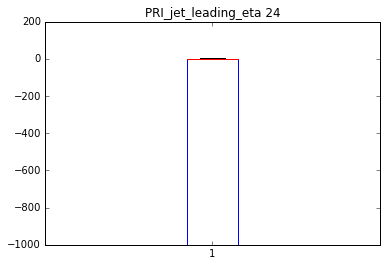

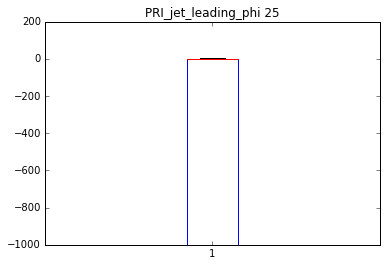

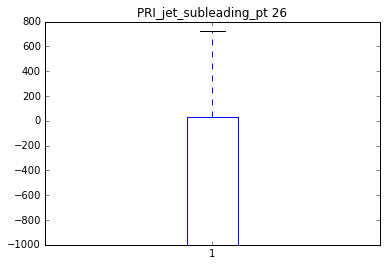

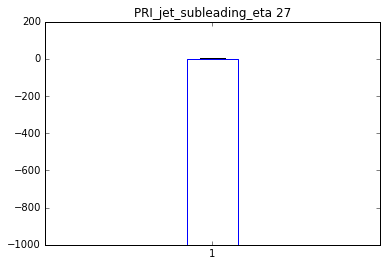

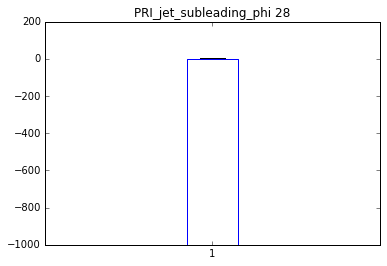

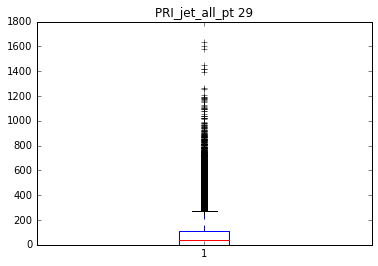

In [165]:
names=pd_data.columns.values

for i in range(tX_starting.shape[1]):
    plt.figure()
    plt.title(names[i+1]+" "+str(i))
    plt.boxplot(tX_starting[:,i])

# Preprocessing

In [281]:
drop_columns=[]
for i in range(tX_starting.shape[1]):
    coeff=np.corrcoef(y,tX_starting[:,i])[0,1]
    if abs(coeff)<0.000:
        drop_columns.append(i)
tX=np.delete(tX_starting,drop_columns,axis=1)
tX.shape

(250000, 30)

In [282]:
def build_poly(tX,degree,ones=True):
    # Add ones column
    if ones:
        ones=np.ones(tX.shape[0]).reshape([tX.shape[0],1])
        tX=np.concatenate((tX,ones),axis=1)
    for i in range(2,degree+1):
        tX=np.concatenate((tX,tX[:,range(30)]**i),axis=1)
    return tX

In [283]:
tX=build_poly(tX,2)
tX.shape

(250000, 61)

In [284]:
#tX[tX==-999]=0

In [285]:
# Normalizing
#mean=np.sum(tX,axis=0)/tX.shape[0]
#std=np.sqrt(np.sum(tX**2,axis=0)/tX.shape[0])
#tX=(tX-mean)/std

In [286]:
tX.shape

(250000, 61)

# Splitting data

In [287]:
def split_data(x, y, ratio, seed=1):
    """split the dataset based on the split ratio."""
    # set seed
    np.random.seed(seed)
    print(x.shape)
    train_elements=int(ratio*x.shape[0])
    test_elements=x.shape[0]-train_elements
    print(train_elements,test_elements)
    indices = np.random.permutation(x.shape[0])
    training_idx, test_idx = indices[:train_elements], indices[train_elements:]
    x_train, x_test = x[training_idx], x[test_idx]
    y_train, y_test = y[training_idx], y[test_idx]
    return x_train,x_test,y_train,y_test

In [288]:
tX_train,tX_test,y_train,y_test=split_data(tX,y,0.5,1)
tX_test.shape

(250000, 61)
125000 125000


(125000, 61)

## Do your thing crazy machine learning thing here :) ...

In [289]:
def compute_predictions(tX,w):
    prediction=tX.dot(w)
    prediction[np.where(prediction <= 0)] = -1
    prediction[np.where(prediction > 0)] = 1
    return prediction

In [290]:
def evaluate_prediction(prediction,y):
    return (sum(y*prediction)/y.shape[0]+1)/2

In [291]:
def evaluate(y,tX,w):
    prediction=compute_predictions(tX,w)
    return evaluate_prediction(prediction,y)

In [292]:
def compute_loss(y, tX, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    error= y-tX.dot(w)
    square=np.sum(error**2)/error.shape[0]
    return square

In [293]:
def compute_gradient(y, tX, w):
    """Compute the gradient."""
    N=tX.shape[0]
    error=y-tX.dot(w)
    gradient=-1.0/N*(np.transpose(tX).dot(error))
    return gradient
        
compute_gradient(y_train,tX_train,np.zeros([tX_train.shape[1]])).shape

(61,)

In [294]:
def gradient_descent(y, tX, initial_w, max_iters, gamma): 
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # Compute gradient and loss
        gradient=compute_gradient(y,tX,w)
        loss=compute_loss(y,tX,w)
        # Update w by gradient
        w=w-gamma*gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}".format(
              bi=n_iter, ti=max_iters - 1, l=loss))

    print(w.shape)
    return loss, w

In [295]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient for batch data."""
    N=tx.shape[0]
    error=y-tx.dot(w)
    gradient=-1.0/N*(np.transpose(tx).dot(error))
    return gradient


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_epochs, gamma):
    """Stochastic gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    y_shuffle=[]
    tx_shuffle=[]
    for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
        y_shuffle.append(minibatch_y)
        tx_shuffle.append(minibatch_tx)
    for n_iter in range(max_epochs):
        # compute stochastic gradient
        gradient=compute_stoch_gradient(y_shuffle[n_iter],tx_shuffle[n_iter],w)
        loss=compute_loss(y,tx,w)
        # update w
        w=w-gamma*gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return loss, w

In [296]:
# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.00001

# Initialization
w_initial = np.ones(tX.shape[1])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, w = gradient_descent(y, tX, w_initial, max_iters, gamma)
#gradient_losses, w = stochastic_gradient_descent(y_train, tX_train, w_initial,30, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

print(sum((y_test-tX_test.dot(w))**2)/tX_test.shape[0])

Gradient Descent(0/49): loss=58902411964477.9
Gradient Descent(1/49): loss=1.9370816864098116e+29
Gradient Descent(2/49): loss=6.403990007164676e+44
Gradient Descent(3/49): loss=2.1172002623459746e+60
Gradient Descent(4/49): loss=6.99960102825525e+75
Gradient Descent(5/49): loss=2.3141133819446934e+91
Gradient Descent(6/49): loss=7.65060854598104e+106
Gradient Descent(7/49): loss=2.5293406788327815e+122
Gradient Descent(8/49): loss=8.36216391303799e+137
Gradient Descent(9/49): loss=2.764585486395751e+153
Gradient Descent(10/49): loss=9.13989846536426e+168
Gradient Descent(11/49): loss=3.021709560736998e+184
Gradient Descent(12/49): loss=9.989967289079172e+199
Gradient Descent(13/49): loss=3.3027478131462365e+215
Gradient Descent(14/49): loss=1.0919097932549594e+231
Gradient Descent(15/49): loss=3.609924414635587e+246
Gradient Descent(16/49): loss=1.1934643649028278e+262
Gradient Descent(17/49): loss=3.9456703983002776e+277
Gradient Descent(18/49): loss=1.3044641591197127e+293
Gradient 

In [297]:
def least_squares(y, tx):
    """calculate the least squares solution."""
    # returns mse, and optimal weights
    
    w=np.linalg.solve(tx.T.dot(tx),tx.T.dot(y))
    mse=sum((y-tx.dot(w))**2)/tx.shape[0]
    
    return mse,w
    
mse,w=least_squares(y_train,tX_train)
print(evaluate(y_train,tX_train,w))
print(evaluate(y_test,tX_test,w))

0.770736
0.770976


In [298]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    # ***************************************************
    # INSERT YOUR CODE HERE
    # ridge regression: TODO
    # ***************************************************
    w=np.linalg.solve(tx.T.dot(tx)+lamb**2*np.identity(tx.shape[1]),tx.T.dot(y))
    mse=sum((y-tx.dot(w))**2)/tx.shape[0]
    return mse,w

mse,w=ridge_regression(y_train,tX_train,0)
print(mse,w)

0.635667095381 [  3.73681640e-05  -8.86602806e-03  -6.82617209e-03   2.45125579e-03
  -1.83927493e-01   5.35876382e-05  -3.59441074e-02   8.05963988e-01
  -2.84310785e-03  -7.07978532e+00  -3.33992346e-01   5.79658244e-02
   3.87991331e-01   7.08985522e+00  -9.50560827e-04   6.72814210e-04
   7.09535866e+00  -4.23069525e-04  -2.96679659e-06   9.63926518e-04
   1.57157885e-04   3.04704665e-04   5.09018435e+04   1.97719176e-03
  -1.94029010e-04   1.50402123e-03   1.36013514e-03   1.06192893e-03
  -2.23012938e-03   7.07928747e+00  -6.10836934e+04   1.98721183e-08
   2.26810017e-05   4.59672454e-06  -1.39373882e-06   2.22782250e-02
  -2.69554289e-08  -2.19878638e-03  -9.41767789e-02   2.50967089e-05
  -1.36727579e-06   2.66994056e-02   3.67106306e-02  -2.95111495e-02
  -1.82063533e-05  -2.29612110e-02  -9.52336281e-04  -3.43238486e-05
  -3.66764106e-02  -9.44692813e-04   1.20523848e-06  -1.02208435e-03
  -1.13600957e-06  -1.01804017e+04  -3.37264712e-06   4.11588350e-02
  -3.48946183e-04  

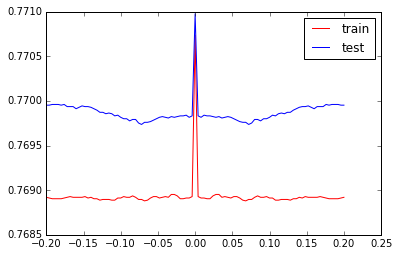

In [302]:
perc_tr=[]
perc_te=[]

lambdas = np.linspace(-0.2,0.2,101)
for lamb in lambdas:
    mse,w=ridge_regression(y_train,tX_train,lamb)
    
    perc_tr.append(evaluate(y_train,tX_train,w))
    perc_te.append(evaluate(y_test,tX_test,w))
    

plt.plot(lambdas,perc_tr,label='train',color='r')
plt.plot(lambdas,perc_te,label='test')
plt.legend()

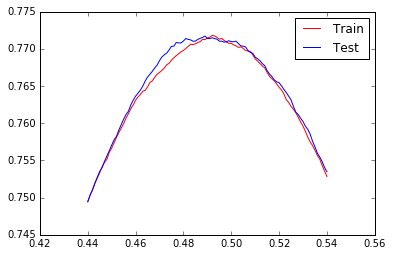

In [300]:
# Basic implementation of logistic regression using the least squares
def logistic_regression(y,tx,tx_test,threshold=0.5):
    mse,w=least_squares(y,tx)
    
    y_prev=tx.dot(w)
    y_prev=1/(1+np.exp(-y_prev))
    output_train=np.ones(y_prev.shape[0])
    output_train[np.where(y_prev<threshold)] = -1
    
    y_test=tx_test.dot(w)
    y_test=1/(1+np.exp(-y_test))
    output_test=np.ones(y_test.shape[0])
    output_test[np.where(y_test<threshold)] = -1
    
    return output_train,output_test

thresholds=np.linspace(0.44,0.54,101)
perc_log_tr=[]
perc_log_te=[]
for threshold in thresholds:
    output_train,output_test=logistic_regression(y_train,tX_train,tX_test,threshold)
    perc_log_tr.append(evaluate_prediction(output_train,y_train))
    perc_log_te.append(evaluate_prediction(output_test,y_test))

    
plt.plot(thresholds,perc_log_tr,'r',label='Train')
plt.plot(thresholds,perc_log_te,'b',label='Test')
plt.legend()

# Test on training dataset

In [101]:
tX_test_post=np.copy(tX_test)
tX_test_post[tX_test_post==-999]=0
prediction=compute_predictions(tX_test,w)
evaluate_prediction(prediction,y_test)

0.74408


In [102]:
print(sum((y_test-tX_test.dot(w))**2)/tX_test.shape[0])
print(tX_test.dot(w))

0.679200660386
[ 0.36798717  0.07112672 -0.44525183 ..., -0.58630253 -0.04988734
 -0.42791098]


## Generate predictions and save ouput in csv format for submission:

In [252]:
DATA_TEST_PATH = '../../test.csv' # TODO: download train data and supply path here 
_, tX_final_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [276]:
tX_final_test=build_poly(tX_final_test,2)

In [277]:
OUTPUT_PATH = '../../predictions.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(w, tX_final_test)
y_train,y_test = logistic_regression(y_train,tX_train,tX_final_test,0.48)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)
print(y_pred)

[-1. -1. -1. ...,  1. -1. -1.]
